In [1]:
import re
import string

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# from bokeh.plotting import markers
from scipy.stats import alpha
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter

In [2]:
from sklearn.pipeline import Pipeline
from sklearn import model_selection, preprocessing, linear_model, metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import ensemble
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import learning_curve, train_test_split, cross_val_score

In [3]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
# from textblob import Word
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/xanderquinn/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/xanderquinn/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
train = pd.read_csv('../Datasets/EnglishDatasets/Twitter_Data.csv')
test = pd.read_csv('../Datasets/EnglishDatasets/twitter_testing.csv')
test_ex = pd.read_csv('../Datasets/EnglishDatasets/sentiment_data.csv')

In [5]:
print(train.shape)
print(test.shape)
print(test_ex.shape)

(162980, 2)
(74681, 4)
(241145, 3)


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162980 entries, 0 to 162979
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   clean_text  162976 non-null  object 
 1   category    162973 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.5+ MB


In [7]:
# remove the null Value in the train
train.dropna(inplace=True)

In [8]:
test.dropna(inplace=True)
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 73990 entries, 0 to 74680
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Id         73990 non-null  int64 
 1   Brand      73990 non-null  object
 2   Sentiment  73990 non-null  object
 3   Text       73990 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.8+ MB


In [9]:
# test_ex.dropna(inplace=True)

In [10]:
test_ex.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 241145 entries, 0 to 241144
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  241145 non-null  int64 
 1   Comment     240928 non-null  object
 2   Sentiment   241145 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 5.5+ MB


In [11]:
train.head()

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


In [12]:
train.describe()

,category
count,162969.000000
mean,0.225442
std,0.781279
min,-1.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [13]:
temp = train.groupby('category').count()['clean_text'].reset_index().sort_values(by='clean_text',ascending=False)
temp.style.background_gradient(cmap='Purples')

,category,clean_text
2,1.000000,72249
1,0.000000,55211
0,-1.000000,35509


<Axes: xlabel='category', ylabel='count'>

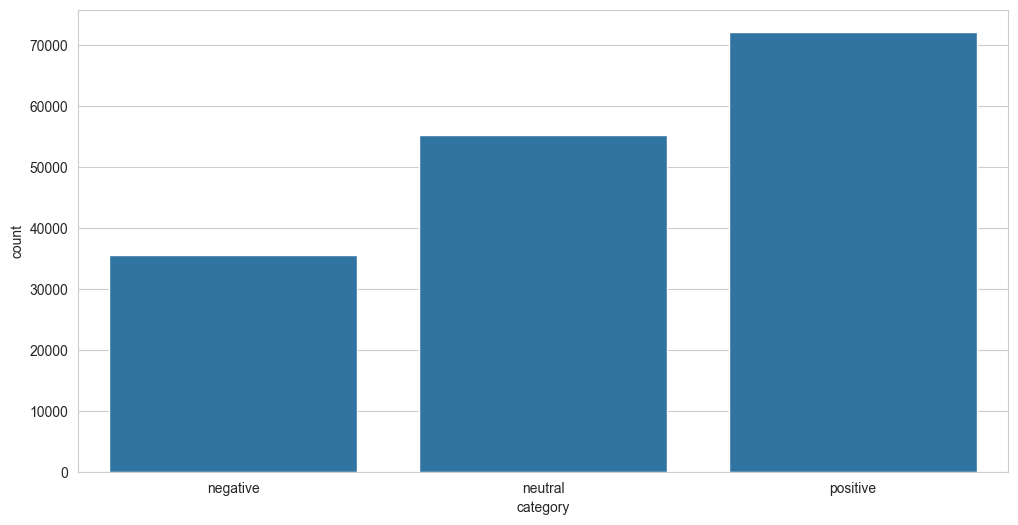

In [14]:
sentiment_map = {
    0: 'neutral',
    1: 'positive',
    -1: 'negative'
}
train['category'] = train['category'].astype('Int64')
train['category'] = train['category'].map(sentiment_map)
plt.figure(figsize=(12,6))
sns.countplot(x='category', data=train)

In [15]:
# external test dataset
sentiment_map_external = {
    0: 'negative',
    1: 'neutral',
    2: 'positive'
}
# test_ex['Sentiment'] = test_ex['Sentiment'].astype('Int64')
test_ex['Sentiment'] = test_ex['Sentiment'].map(sentiment_map_external)

In [16]:
emoji_pattern = re.compile(
    "["
    "\U0001F600-\U0001F64F"  # emoticons
    "\U0001F300-\U0001F5FF"  # symbols & pictographs
    "\U0001F680-\U0001F6FF"  # transport & map symbols
    "\U0001F1E0-\U0001F1FF"  # flags
    "\U00002700-\U000027BF"  # dingbats
    "\U0001F900-\U0001F9FF"  # supplemental symbols
    "]+",
    flags=re.UNICODE
)
def clean_context(text):
    text = str(text).lower()
    text = re.sub(r'https?://\S+|www\.\S+|\S+\.\S+/\S+', '', text)
    text = emoji_pattern.sub(r'', text)
    text = re.sub(r'@[^\s]+', ' ', text)
    text = re.sub(r'\[.*?\]', ' ', text)
    text = re.sub(r'<.*?>', ' ', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub(r'\n', '', text)
    text = re.sub(r'\b\w*\d\w*\b', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [17]:
train['clean_text'] = train['clean_text'].apply(lambda x: clean_context(x))

In [18]:
train.head()

,clean_text,category
0,when modi promised “minimum government maximum...,negative
1,talk all the nonsense and continue all the dra...,neutral
2,what did just say vote for modi welcome bjp to...,positive
3,asking his supporters prefix chowkidar their n...,positive
4,answer who among these the most powerful world...,positive


In [19]:
test['Text'] = test['Text'].apply(lambda x: clean_context(x))
test['Sentiment'] = test['Sentiment'].str.lower()

In [20]:
test.head()

,Id,Brand,Sentiment,Text
0,2401,Borderlands,positive,i am coming to the borders and i will kill you...
1,2401,Borderlands,positive,im getting on borderlands and i will kill you all
2,2401,Borderlands,positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,positive,im getting on borderlands and i will murder yo...
4,2401,Borderlands,positive,im getting into borderlands and i can murder y...


In [21]:
test_ex['Comment'] = test_ex['Comment'].apply(lambda x: clean_context(x))

In [22]:
test_ex.head()

,Unnamed: 0,Comment,Sentiment
0,0,lets forget apple pay required brand new iphon...,neutral
1,1,nz retailers don’t even contactless credit car...,negative
2,2,forever acknowledge channel help lessons ideas...,positive
3,3,whenever go place doesn’t take apple pay doesn...,negative
4,4,apple pay convenient secure easy use used kore...,positive


In [23]:
text_1 = "Rock-Hard La Varlope (Xbox) dlvr.it/RMTrgF"
clean = re.sub(r'https?://\S+|www\.\S+|\S+\.\S+/\S+', '', text_1)
print(clean)

Rock-Hard La Varlope (Xbox) 


In [24]:
train['temp_list'] = train['clean_text'].apply(lambda x:str(x).split())
top = Counter([item for sublist in train['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,modi,149744
1,the,103969
2,and,66826
3,for,52240
4,you,38259
5,not,29182
6,will,28821
7,this,28102
8,are,27924
9,india,27650


In [25]:
fig = px.bar(temp, x="count", y="Common_words", title='Commmon Words in Selected Text', orientation='h',
             width=700, height=700,color='Common_words')
fig.show()

In [26]:
# remove the stop words
stop_words = set(stopwords.words('english'))
def remove_stopword(x):
    return [y for y in x if y not in stop_words]
train['temp_list'] = train['temp_list'].apply(lambda x: remove_stopword(x))

In [27]:
train.head()

,clean_text,category,temp_list
0,when modi promised “minimum government maximum...,negative,"[modi, promised, “minimum, government, maximum..."
1,talk all the nonsense and continue all the dra...,neutral,"[talk, nonsense, continue, drama, vote, modi]"
2,what did just say vote for modi welcome bjp to...,positive,"[say, vote, modi, welcome, bjp, told, rahul, m..."
3,asking his supporters prefix chowkidar their n...,positive,"[asking, supporters, prefix, chowkidar, names,..."
4,answer who among these the most powerful world...,positive,"[answer, among, powerful, world, leader, today..."


In [28]:
# test['temp_list'] = test['Text'].apply(lambda x:str(x).split())
# test['temp_list'] = test['temp_list'].apply(lambda x: remove_stopword(x))

In [29]:
test.head()

,Id,Brand,Sentiment,Text
0,2401,Borderlands,positive,i am coming to the borders and i will kill you...
1,2401,Borderlands,positive,im getting on borderlands and i will kill you all
2,2401,Borderlands,positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,positive,im getting on borderlands and i will murder yo...
4,2401,Borderlands,positive,im getting into borderlands and i can murder y...


In [30]:
# test_ex['temp_list'] = test_ex['Comment'].apply(lambda x: str(x).split())
# test_ex['temp_list'] = test_ex['temp_list'].apply(lambda x: remove_stopword(x))

In [31]:
test_ex.head()

,Unnamed: 0,Comment,Sentiment
0,0,lets forget apple pay required brand new iphon...,neutral
1,1,nz retailers don’t even contactless credit car...,negative
2,2,forever acknowledge channel help lessons ideas...,positive
3,3,whenever go place doesn’t take apple pay doesn...,negative
4,4,apple pay convenient secure easy use used kore...,positive


In [32]:
top = Counter([item for sublist in train['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp = temp.iloc[1:,:]
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Purples')

,Common_words,count
1,india,27650
2,bjp,14148
3,people,13610
4,like,12519
5,congress,12435
6,narendra,11358
7,govt,9725
8,one,9178
9,vote,9024
10,dont,8283


In [33]:
Positive_sent = train[train['category'] == 'positive']
Negative_sent = train[train['category'] == 'negative']
Neutral_sent = train[train['category'] == 'neutral']

In [34]:
top = Counter([item for sublist in Positive_sent['temp_list'] for item in sublist])
# the most common words in different sentiments
temp_positive = pd.DataFrame(top.most_common(20))
temp_positive = temp_positive.iloc[1:,:]
temp_positive.columns = ['Common_words','count']
temp_positive.style.background_gradient(cmap='Greens')

,Common_words,count
1,india,15228
2,bjp,6837
3,people,6805
4,like,6058
5,congress,5629
6,narendra,5478
7,one,4910
8,govt,4763
9,good,4720
10,vote,4274


In [35]:
fig = px.bar(temp_positive, x="count", y="Common_words", title='Commmon Words in Selected Text', orientation='h',
             width=700, height=700,color='Common_words')
fig.show()

In [36]:
top = Counter([item for sublist in Negative_sent['temp_list'] for item in sublist])
temp_negative = pd.DataFrame(top.most_common(20))
temp_negative = temp_negative.iloc[1:,:]
temp_negative.columns = ['Common_words','count']
temp_negative.style.background_gradient(cmap='Greens')

,Common_words,count
1,india,6028
2,people,3982
3,bjp,3493
4,like,3427
5,congress,3350
6,poor,2569
7,govt,2533
8,dont,2300
9,one,2235
10,even,2038


In [37]:
fig = px.bar(temp_negative, x="count", y="Common_words", title='Commmon Words in Selected Text', orientation='h',
             width=700, height=700,color='Common_words')
fig.show()

In [38]:
top = Counter([item for sublist in Neutral_sent['temp_list'] for item in sublist])
temp_neutral = pd.DataFrame(top.most_common(20))
temp_neutral = temp_neutral.iloc[1:,:]
temp_neutral.columns = ['Common_words','count']
temp_neutral.style.background_gradient(cmap='Greens')

,Common_words,count
1,india,6394
2,narendra,3991
3,bjp,3818
4,congress,3456
5,like,3034
6,vote,2958
7,people,2823
8,modis,2616
9,govt,2429
10,dont,2219


In [39]:
fig = px.bar(temp_neutral, x="count", y="Common_words", title='Commmon Words in Selected Text', orientation='h',
             width=700, height=700,color='Common_words')
fig.show()

In [40]:
X = train['clean_text']
y = train['category']

x_test = test['Text']
y_test = test['Sentiment']

x_test_external1 = test_ex['Comment']
y_test_external1 = test_ex['Sentiment']

# divide train datasets 80% training 20% testing
train_x, test_x, train_y, test_y = model_selection.train_test_split(X, y, test_size = 0.20, shuffle = True, random_state = 11)

In [41]:
X.head()

0    when modi promised “minimum government maximum...
1    talk all the nonsense and continue all the dra...
2    what did just say vote for modi welcome bjp to...
3    asking his supporters prefix chowkidar their n...
4    answer who among these the most powerful world...
Name: clean_text, dtype: object

In [42]:
# Embeddings or Vectorization

In [43]:
# train_x = train_x.fillna("")
# test_x = test_x.fillna("")
# back to string
# x_test = x_test.fillna("")
# x_test_external1_str = x_test_external1.fillna("")
# TF-IDF
tf_idf_word_vectorizer = TfidfVectorizer()
tf_idf_word_vectorizer.fit(train_x)

x_train_tf_idf_word = tf_idf_word_vectorizer.transform(train_x)
x_test_tf_idf_word = tf_idf_word_vectorizer.transform(test_x)

x_test_external = tf_idf_word_vectorizer.transform(x_test)
x_test_external_tf_idf = tf_idf_word_vectorizer.transform(x_test_external1)

# sample = x_train_tf_idf_word[:2000].toarray()

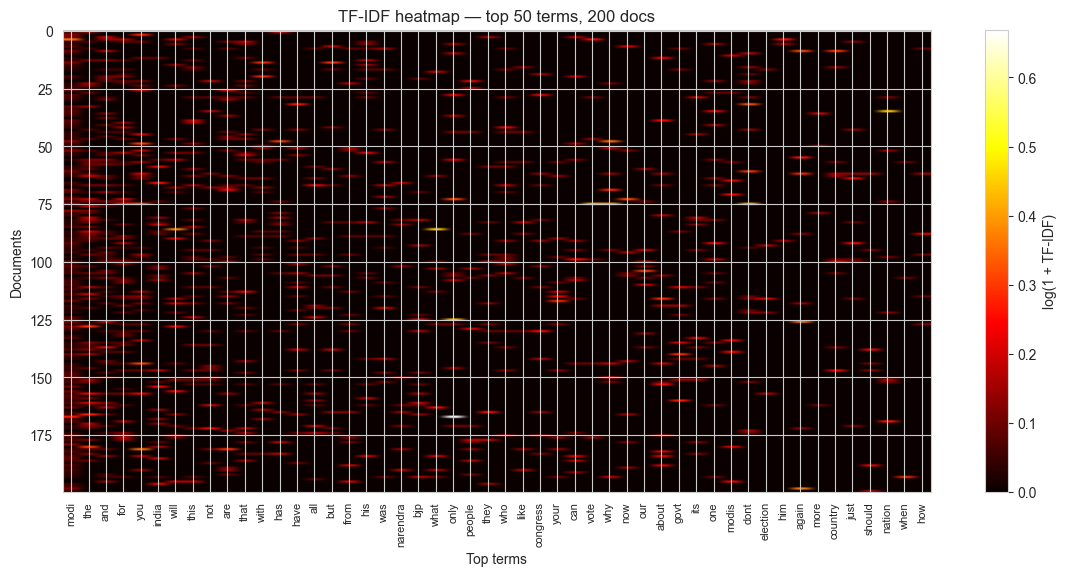

In [44]:
# 參數
top_k = 50       # 顯示前 50 個詞
n_docs = 200     # 顯示前 200 條文件（或隨機抽樣）

# 計算每個詞的總權重並取 top_k index
term_sums = np.array(x_train_tf_idf_word.sum(axis=0)).ravel()
top_indices = np.argsort(term_sums)[::-1][:top_k]

# 取得 sample 矩陣（documents x top_k terms）
sample = x_train_tf_idf_word[:n_docs, :][:, top_indices].toarray()

# 用 log1p 放大小值差異（避免 0 與極小值全是黑）
sample_log = np.log1p(sample)

plt.figure(figsize=(14, 6))
plt.imshow(sample_log, aspect='auto', cmap='hot')
plt.colorbar(label='log(1 + TF-IDF)')
plt.xlabel('Top terms')
plt.ylabel('Documents')
plt.title(f'TF-IDF heatmap — top {top_k} terms, {n_docs} docs')

# x 軸標籤：顯示詞名（可能會擠，選間隔顯示）
terms = tf_idf_word_vectorizer.get_feature_names_out()
plt.xticks(ticks=np.arange(top_k), labels=terms[top_indices], rotation=90, fontsize=8)
plt.show()

In [45]:
# Training
log = linear_model.LogisticRegression(max_iter=1000)
log_model = log.fit(x_train_tf_idf_word, train_y)
accuracy = model_selection.cross_val_score(log_model,
                                           x_test_tf_idf_word, test_y, cv=20).mean()
print("Accuracy: ", accuracy)

Accuracy:  0.8615083588486293


<Figure size 700x600 with 0 Axes>

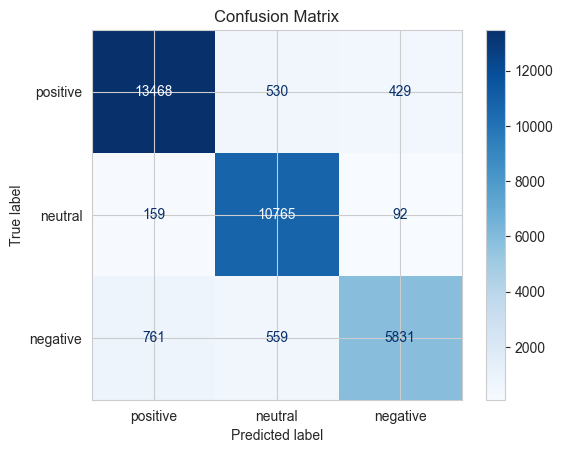

In [46]:
# Confusion Matrix
y_pred = log_model.predict(x_test_tf_idf_word)

cm = confusion_matrix(test_y, y_pred, labels=['positive', 'neutral', 'negative'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['positive', 'neutral', 'negative'])
plt.figure(figsize=(7, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()

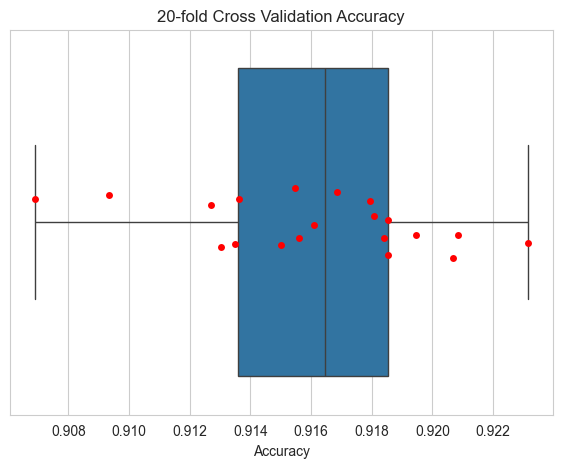

Mean: 0.9161879811654474
Std: 0.003843834841215548


In [47]:
# Cross-validation check the stability of the model
scores = model_selection.cross_val_score(log_model, x_train_tf_idf_word, train_y, cv=20)

plt.figure(figsize=(7,5))
sns.boxplot(x=scores)
sns.stripplot(x=scores, color='red', size=5, jitter=True)
plt.title("20-fold Cross Validation Accuracy")
plt.xlabel("Accuracy")
plt.show()

print("Mean:", scores.mean())
print("Std:", scores.std())

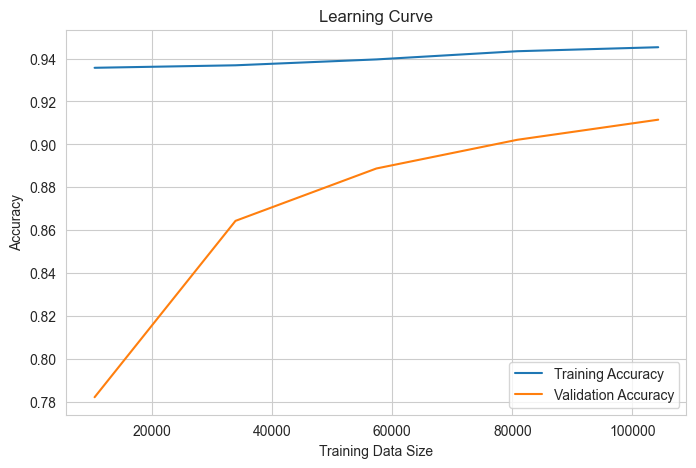

In [48]:
# Learning Curve
train_sizes, train_scores, valid_scores = learning_curve(
    log_model, x_train_tf_idf_word, train_y,
    train_sizes=np.linspace(0.1, 1.0, 5),
    cv=5
)

train_mean = train_scores.mean(axis=1)
valid_mean = valid_scores.mean(axis=1)

plt.figure(figsize=(8,5))
plt.plot(train_sizes, train_mean, label='Training Accuracy')
plt.plot(train_sizes, valid_mean, label='Validation Accuracy')
plt.xlabel("Training Data Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve")
plt.legend()
plt.grid(True)
plt.show()

In [49]:
accuracy = model_selection.cross_val_score(log_model,
                                           x_test_external, y_test, cv=20).mean()
print("Accuracy: ", accuracy)

Accuracy:  0.4466925282947181


<Figure size 700x600 with 0 Axes>

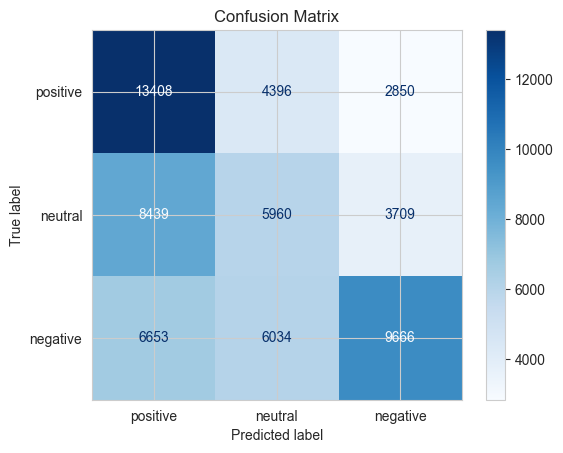

In [50]:
# Confusion Matrix
y_test_pred = log_model.predict(x_test_external)

cm = confusion_matrix(y_test, y_test_pred, labels=['positive', 'neutral', 'negative'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['positive', 'neutral', 'negative'])
plt.figure(figsize=(7, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()

In [51]:
accuracy = model_selection.cross_val_score(log_model,
                                           x_test_external_tf_idf, y_test_external1, cv=20).mean()
print("Accuracy: ", accuracy)

Accuracy:  0.7801967441846454


<Figure size 700x600 with 0 Axes>

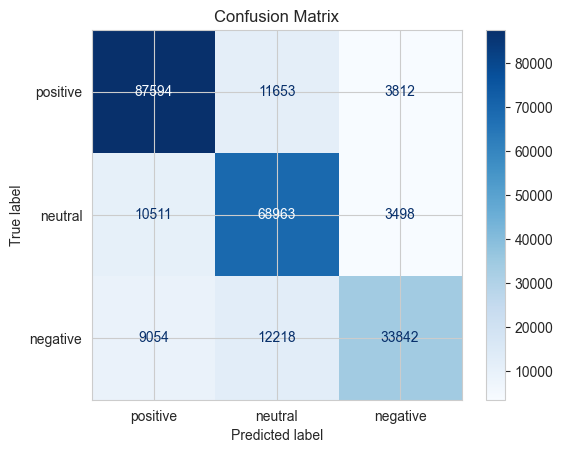

In [52]:
# Confusion Matrix
y_test_external_pred = log_model.predict(x_test_external_tf_idf)

cm = confusion_matrix(y_test_external1, y_test_external_pred, labels=['positive', 'neutral', 'negative'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['positive', 'neutral', 'negative'])
plt.figure(figsize=(7, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()

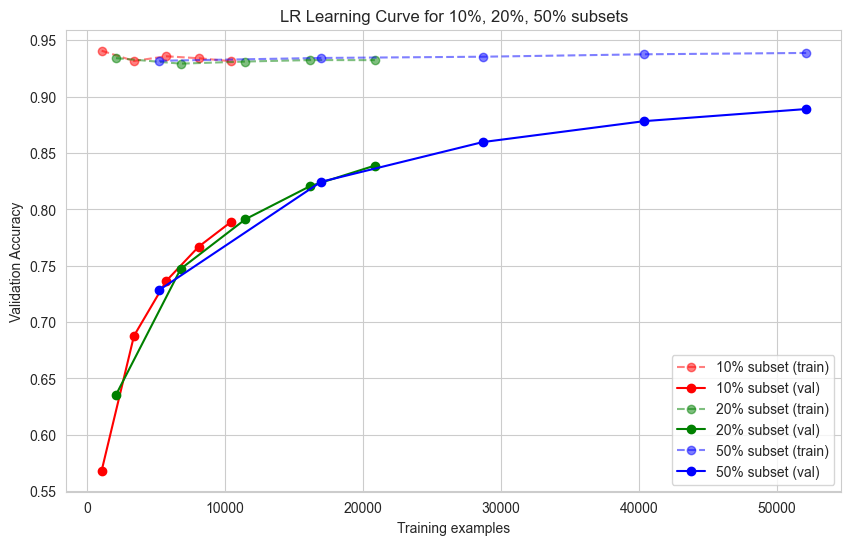

In [53]:
# divide training set to 10%,20%,50%
subset_sizes = [0.1, 0.2, 0.5]
sub_labels = ["10% subset", "20% subset", "50% subset"]
colors = ["red", "green", "blue"]

plt.figure(figsize=(10, 6))

for size, label, c in zip(subset_sizes, sub_labels, colors):
    # extract training subsets
    # The Hitchhiker’s Guide to the Galaxy!
    X_sub, _, y_sub, _ = train_test_split(
        train_x, train_y, train_size=size, random_state=42, shuffle=True
    )

    # establish pipeline
    lr_model = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('clf', LogisticRegression(max_iter=1000))
    ])

    # learning curve
    train_sizes, train_scores, val_scores = learning_curve(
        lr_model,
        X_sub, y_sub,
        train_sizes=np.linspace(0.1, 1.0, 5),
        cv=5,
        n_jobs=-1
    )

    # create validation curve
    train_mean = train_scores.mean(axis=1)
    val_mean = val_scores.mean(axis=1)

    plt.plot(train_sizes, train_mean, '--', marker='o', color=c, alpha=0.5, label=f"{label} (train)")
    plt.plot(train_sizes, val_mean, '-', marker='o', color=c, label=f"{label} (val)")

plt.xlabel("Training examples")
plt.ylabel("Validation Accuracy")
plt.title("LR Learning Curve for 10%, 20%, 50% subsets")
plt.legend()
plt.grid(True)
plt.savefig("En_LR_learningCurve.pdf", bbox_inches='tight')
plt.show()

In [54]:
# Naive Bayes
nb_model = Pipeline([
    ('tfidf', TfidfVectorizer(
        stop_words='english',
        lowercase=True,
        token_pattern=r'\b\w+\b'
    )),
    ('clf', MultinomialNB())
])

# training
nb_model.fit(train_x, train_y)

# testing
nb_pred = nb_model.predict(test_x)
nb_ex_pred = nb_model.predict(x_test_external1)

print("Naive Bayes Accuracy: ", accuracy_score(nb_pred, test_y))
print("External Dataset Naive Bayes Accuracy: ", accuracy_score(nb_ex_pred, y_test_external1))

Naive Bayes Accuracy:  0.5706264956740504
External Dataset Naive Bayes Accuracy:  0.5856061705612805


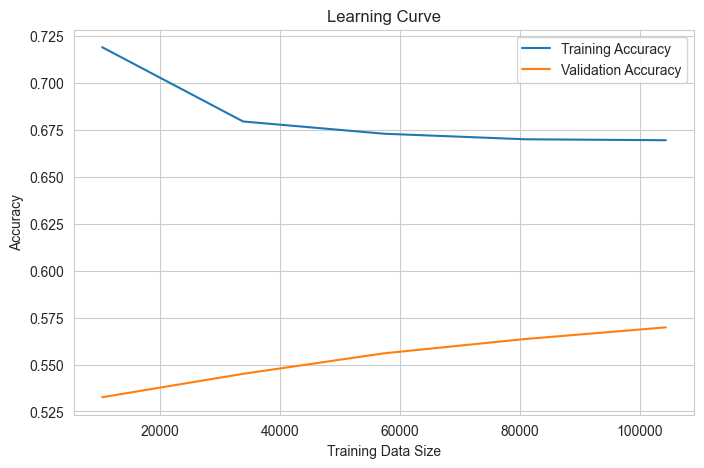

In [55]:
# Learning Curve
train_sizes, train_scores, valid_scores = learning_curve(
    nb_model,
    train_x, train_y,
    train_sizes=np.linspace(0.1, 1.0, 5),
    cv=5
)

train_mean = train_scores.mean(axis=1)
valid_mean = valid_scores.mean(axis=1)

plt.figure(figsize=(8,5))
plt.plot(train_sizes, train_mean, label='Training Accuracy')
plt.plot(train_sizes, valid_mean, label='Validation Accuracy')
plt.xlabel("Training Data Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve")
plt.legend()
plt.grid(True)
plt.show()

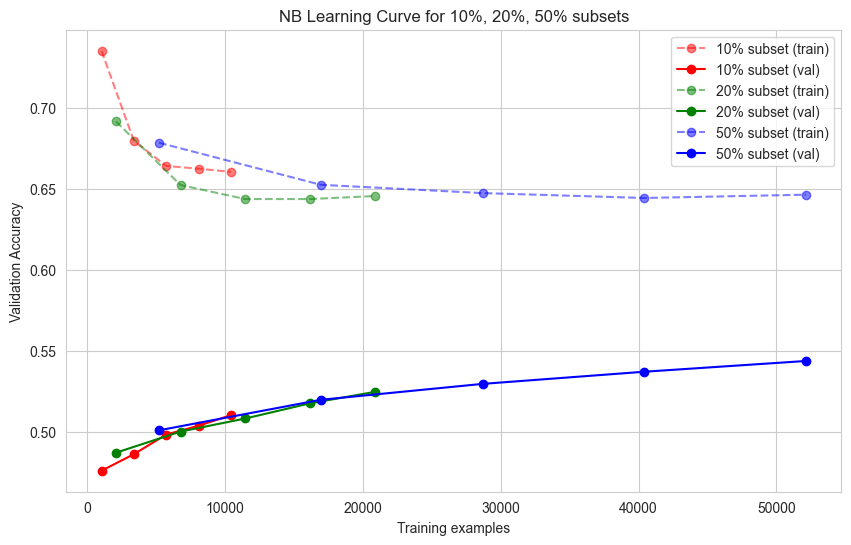

In [56]:
# divide training set to 10%,20%,50%
subset_sizes = [0.1, 0.2, 0.5]
sub_labels = ["10% subset", "20% subset", "50% subset"]
colors = ["red", "green", "blue"]

plt.figure(figsize=(10, 6))

for size, label, c in zip(subset_sizes, sub_labels, colors):
    # extract training subsets
    # The Hitchhiker’s Guide to the Galaxy!
    X_sub, _, y_sub, _ = train_test_split(
        train_x, train_y, train_size=size, random_state=42, shuffle=True
    )

    # establish pipeline
    nb_model = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('clf', MultinomialNB())
    ])

    # learning curve
    train_sizes, train_scores, val_scores = learning_curve(
        nb_model,
        X_sub, y_sub,
        train_sizes=np.linspace(0.1, 1.0, 5),
        cv=5,
        n_jobs=-1
    )

    # create validation curve
    train_mean = train_scores.mean(axis=1)
    val_mean = val_scores.mean(axis=1)

    plt.plot(train_sizes, train_mean, '--', marker='o', color=c, alpha=0.5, label=f"{label} (train)")
    plt.plot(train_sizes, val_mean, '-', marker='o', color=c, label=f"{label} (val)")

plt.xlabel("Training examples")
plt.ylabel("Validation Accuracy")
plt.title("NB Learning Curve for 10%, 20%, 50% subsets")
plt.legend()
plt.grid(True)
plt.savefig("En_NB_LearningCurve.pdf", bbox_inches='tight')
plt.show()

In [57]:
# SVM
svm_model = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LinearSVC(max_iter=1000))
])

# training
svm_model.fit(train_x, train_y)

# testing
svm_pred = svm_model.predict(test_x)
svm_ex_pred = svm_model.predict(x_test_external1)

print("SVM Accuracy: ", accuracy_score(svm_pred, test_y))
print("External Dataset SVM Accuracy: ", accuracy_score(svm_ex_pred, y_test_external1))

SVM Accuracy:  0.945450082837332
External Dataset SVM Accuracy:  0.81976404238114


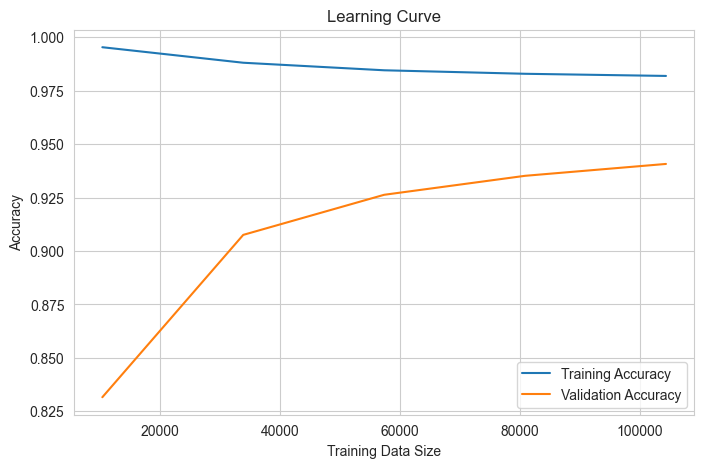

In [58]:
# Learning Curve
train_sizes, train_scores, valid_scores = learning_curve(
    svm_model,
    train_x, train_y,
    train_sizes=np.linspace(0.1, 1.0, 5),
    cv=5
)

train_mean = train_scores.mean(axis=1)
valid_mean = valid_scores.mean(axis=1)

plt.figure(figsize=(8,5))
plt.plot(train_sizes, train_mean, label='Training Accuracy')
plt.plot(train_sizes, valid_mean, label='Validation Accuracy')
plt.xlabel("Training Data Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve")
plt.legend()
plt.grid(True)
plt.show()

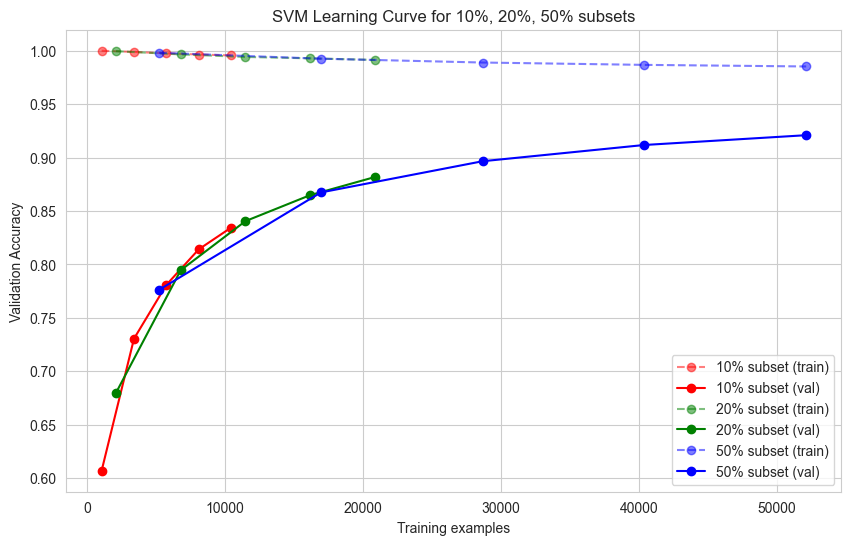

In [59]:
# divide training set to 10%,20%,50%
subset_sizes = [0.1, 0.2, 0.5]
sub_labels = ["10% subset", "20% subset", "50% subset"]
colors = ["red", "green", "blue"]

plt.figure(figsize=(10, 6))

for size, label, c in zip(subset_sizes, sub_labels, colors):
    # extract training subsets
    # The Hitchhiker’s Guide to the Galaxy!
    X_sub, _, y_sub, _ = train_test_split(
        train_x, train_y, train_size=size, random_state=42, shuffle=True
    )

    # establish pipeline
    svm_model = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('clf', LinearSVC(max_iter=1000))
    ])

    # learning curve
    train_sizes, train_scores, val_scores = learning_curve(
        svm_model,
        X_sub, y_sub,
        train_sizes=np.linspace(0.1, 1.0, 5),
        cv=5,
        n_jobs=-1
    )

    # create validation curve
    train_mean = train_scores.mean(axis=1)
    val_mean = val_scores.mean(axis=1)

    plt.plot(train_sizes, train_mean, '--', marker='o', color=c, alpha=0.5, label=f"{label} (train)")
    plt.plot(train_sizes, val_mean, '-', marker='o', color=c, label=f"{label} (val)")

plt.xlabel("Training examples")
plt.ylabel("Validation Accuracy")
plt.title("SVM Learning Curve for 10%, 20%, 50% subsets")
plt.legend()
plt.grid(True)
plt.savefig("En_SVM_LearningCurve.pdf", bbox_inches="tight")
plt.show()

In [60]:
# LogisticRegression
lr_model = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression(max_iter=1000))
])

lr_model.fit(train_x, train_y)
lr_pred = lr_model.predict(test_x)

lr_ex_pred = lr_model.predict(x_test_external1)

print("Logistic Regression Accuracy: ", accuracy_score(lr_pred, test_y))
print("External Test Dataset Accuracy: ", accuracy_score(lr_ex_pred, y_test_external1))

Logistic Regression Accuracy:  0.923237405657483
External Test Dataset Accuracy:  0.7899521035061893


In [61]:
# Comparison
results = {
    "Model": ["Naive Bayes", "Logistic Regression", "SVM"],
    "Accuracy": [
        accuracy_score(test_y, nb_pred),
        accuracy_score(test_y, lr_pred),
        accuracy_score(test_y, svm_pred)
    ]
}

pd.DataFrame(results)

,Model,Accuracy
0,Naive Bayes,0.570626
1,Logistic Regression,0.923237
2,SVM,0.945450


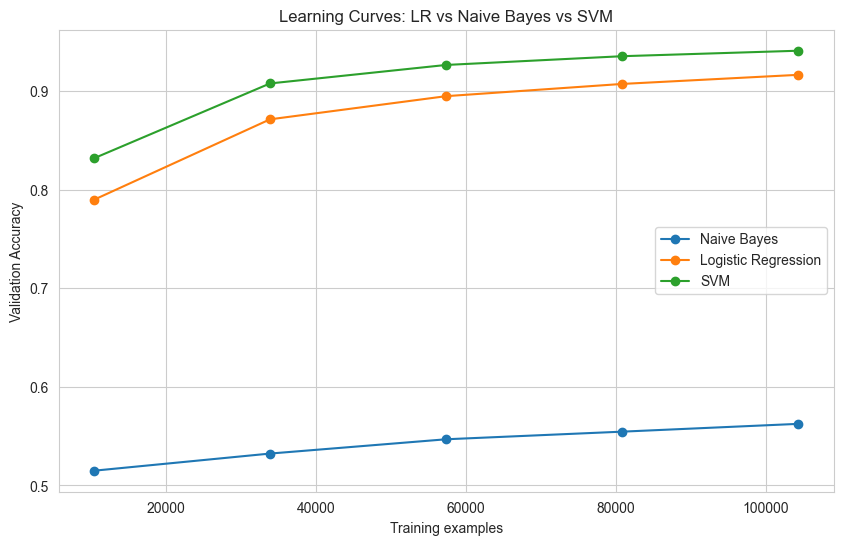

In [62]:
models = {
    "Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM": LinearSVC(max_iter=1000)
}

plt.figure(figsize=(10, 6))

for name, clf in models.items():
    model = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('clf', clf)
    ])

    train_sizes, train_scores, val_scores = learning_curve(
        model, train_x, train_y,
        train_sizes=np.linspace(0.1, 1.0, 5),
        cv=5,
        n_jobs=-1
    )

    val_mean = val_scores.mean(axis=1)
    plt.plot(train_sizes, val_mean, marker='o', label=name)

plt.xlabel("Training examples")
plt.ylabel("Validation Accuracy")
plt.title("Learning Curves: LR vs Naive Bayes vs SVM")
plt.legend()
plt.grid(True)
plt.show()

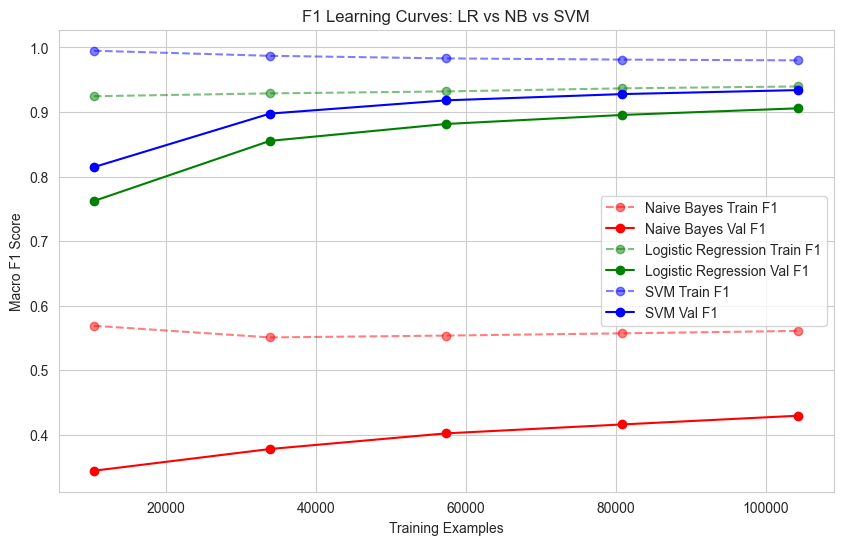

<Figure size 1000x600 with 0 Axes>

In [64]:
# F1 scores curve
models = {
    "Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM": LinearSVC(max_iter=1000)
}
colors = {
    "Naive Bayes": "red",
    "Logistic Regression": "green",
    "SVM": "blue"
}
plt.figure(figsize=(10, 6))
for name, clf in models.items():
    model = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('clf', clf)
    ])

    train_sizes, train_scores, val_scores = learning_curve(
        model, train_x, train_y,
        train_sizes=np.linspace(0.1, 1.0, 5),
        cv=5,
        scoring='f1_macro',
        n_jobs=-1
    )

    train_mean = train_scores.mean(axis=1)
    val_mean = val_scores.mean(axis=1)

    c = colors[name]
    plt.plot(train_sizes, train_mean, '--', marker='o', color=c, alpha=0.5, label=f"{name} Train F1")
    plt.plot(train_sizes, val_mean, '-', marker='o', color=c, label=f"{name} Val F1")

plt.xlabel("Training Examples")
plt.ylabel("Macro F1 Score")
plt.title("F1 Learning Curves: LR vs NB vs SVM")
plt.legend()
plt.grid(True)
plt.savefig("En_F1_LearningCurves.pdf", bbox_inches='tight')
plt.figure(figsize=(10, 6))
# for name, clf in models.items():
plt.show()

In [62]:
print(classification_report(test_y, lr_pred))

              precision    recall  f1-score   support

    negative       0.92      0.82      0.87      7151
     neutral       0.91      0.98      0.94     11016
    positive       0.94      0.93      0.94     14427

    accuracy                           0.92     32594
   macro avg       0.92      0.91      0.91     32594
weighted avg       0.92      0.92      0.92     32594



In [75]:
print(classification_report(test_y, nb_pred))

              precision    recall  f1-score   support

    negative       0.92      0.13      0.22      7151
     neutral       0.84      0.34      0.48     11016
    positive       0.51      0.97      0.67     14427

    accuracy                           0.57     32594
   macro avg       0.76      0.48      0.46     32594
weighted avg       0.71      0.57      0.51     32594



In [64]:
print(classification_report(y_test_external1, nb_ex_pred))

              precision    recall  f1-score   support

    negative       0.91      0.20      0.33     55114
     neutral       0.87      0.38      0.53     82972
    positive       0.52      0.98      0.68    103059

    accuracy                           0.60    241145
   macro avg       0.77      0.52      0.51    241145
weighted avg       0.73      0.60      0.55    241145



In [65]:
print(classification_report(test_y, svm_pred))

              precision    recall  f1-score   support

    negative       0.93      0.88      0.90      7151
     neutral       0.95      0.98      0.97     11016
    positive       0.95      0.95      0.95     14427

    accuracy                           0.95     32594
   macro avg       0.94      0.94      0.94     32594
weighted avg       0.95      0.95      0.95     32594



In [66]:
print(classification_report(y_test_external1, svm_ex_pred))

              precision    recall  f1-score   support

    negative       0.83      0.70      0.76     55114
     neutral       0.80      0.83      0.81     82972
    positive       0.83      0.88      0.85    103059

    accuracy                           0.82    241145
   macro avg       0.82      0.80      0.81    241145
weighted avg       0.82      0.82      0.82    241145



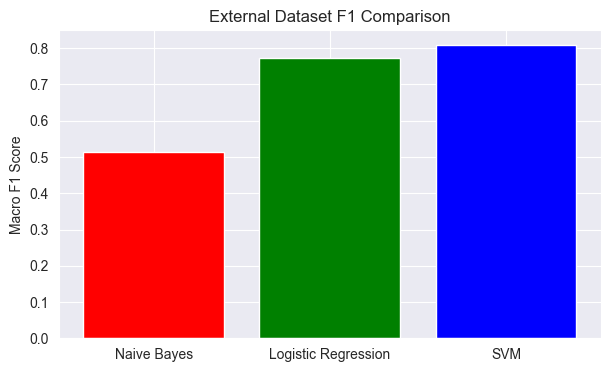

In [67]:
models = {
    "Naive Bayes": nb_ex_pred,
    "Logistic Regression": lr_ex_pred,
    "SVM": svm_ex_pred
}

f1_scores = []

for name, pred in models.items():
    score = f1_score(y_test_external1, pred, average='macro')
    f1_scores.append(score)

plt.figure(figsize=(7,4))
plt.bar(models.keys(), f1_scores, color=['red','green','blue'])
plt.ylabel("Macro F1 Score")
plt.title("External Dataset F1 Comparison")
plt.show()

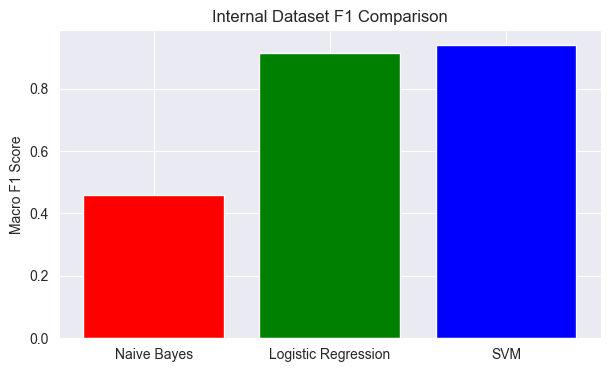

In [76]:
models = {
    "Naive Bayes": nb_pred,
    "Logistic Regression": lr_pred,
    "SVM": svm_pred
}

f1_scores = []

for name, pred in models.items():
    score = f1_score(test_y, pred, average='macro')
    f1_scores.append(score)

plt.figure(figsize=(7,4))
plt.bar(models.keys(), f1_scores, color=['red','green','blue'])
plt.ylabel("Macro F1 Score")
plt.title("Internal Dataset F1 Comparison")
plt.show()

In [108]:
subset_sizes = [0.1, 0.2, 0.5]
sub_labels = ["10% subset", "20% subset", "50% subset"]

for size, label, c in zip(subset_sizes, sub_labels, colors):
    # extract training subsets
    # The Hitchhiker’s Guide to the Galaxy!
    X_sub, X_sub_test, y_sub, y_sub_test = train_test_split(
        train_x, train_y, train_size=size, random_state=42, shuffle=True
    )

    # establish pipeline
    svm_model = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('clf', LinearSVC(max_iter=1000))
    ])

    svm_model.fit(X_sub, y_sub)
    svm_sub_pred = svm_model.predict(X_sub_test)

    print("Subset scale:", size)
    print("SVM Accuracy: ", accuracy_score(svm_sub_pred, y_sub_test))


Subset scale: 0.1
SVM Accuracy:  0.8513780701903901
Subset scale: 0.2
SVM Accuracy:  0.8916395014381592
Subset scale: 0.5
SVM Accuracy:  0.9301251764128368


In [106]:
subset_sizes = [0.1, 0.2, 0.5]
sub_labels = ["10% subset", "20% subset", "50% subset"]

for size, label, c in zip(subset_sizes, sub_labels, colors):
    # extract training subsets
    # The Hitchhiker’s Guide to the Galaxy!
    X_sub, X_sub_test, y_sub, y_sub_test = train_test_split(
        train_x, train_y, train_size=size, random_state=42, shuffle=True
    )

    # establish pipeline
    lr_model = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('clf', LogisticRegression(max_iter=1000))
    ])

    lr_model.fit(X_sub, y_sub)
    lr_sub_pred = lr_model.predict(X_sub_test)

    print("Subset scale:", size)
    print("LR Accuracy: ", accuracy_score(lr_sub_pred, y_sub_test))

Subset scale: 0.1
LR Accuracy:  0.806797456919327
Subset scale: 0.2
LR Accuracy:  0.8503930968360499
Subset scale: 0.5
LR Accuracy:  0.899552064797202


In [113]:
subset_sizes = [0.1, 0.2, 0.5]
sub_labels = ["10% subset", "20% subset", "50% subset"]

for size, label, c in zip(subset_sizes, sub_labels, colors):
    # extract training subsets
    # The Hitchhiker’s Guide to the Galaxy!
    X_sub, X_sub_test, y_sub, y_sub_test = train_test_split(
        train_x, train_y, train_size=size, random_state=42, shuffle=True
    )

    # establish pipeline
    nb_model = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('clf', MultinomialNB())
    ])

    nb_model.fit(X_sub, y_sub)
    nb_sub_pred = nb_model.predict(X_sub_test)

    print("Subset scale:", size)
    print("NB Accuracy: ", accuracy_score(nb_sub_pred, y_sub_test))

Subset scale: 0.1
NB Accuracy:  0.5152209855289847
Subset scale: 0.2
NB Accuracy:  0.5237679769894535
Subset scale: 0.5
NB Accuracy:  0.5501779468613855


In [114]:
sub_train_x, sub_test_x, sub_train_y, sub_test_y = model_selection.train_test_split(X, y, train_size = 0.10, shuffle = True, random_state = 11)

In [118]:
subset_sizes = [0.01, 0.5, 0.9]
sub_labels = ["10% subset", "20% subset", "50% subset"]

for size, label, c in zip(subset_sizes, sub_labels, colors):
    # extract training subsets
    # The Hitchhiker’s Guide to the Galaxy!
    X_sub, X_sub_test, y_sub, y_sub_test = train_test_split(
        sub_train_x, sub_train_y, train_size=size, random_state=42, shuffle=True
    )

    # establish pipeline
    nb_model = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('clf', MultinomialNB())
    ])

    nb_model.fit(X_sub, y_sub)
    nb_sub_pred = nb_model.predict(X_sub_test)

    print("Subset scale:", size)
    print("NB Accuracy: ", accuracy_score(nb_sub_pred, y_sub_test))

Subset scale: 0.01
NB Accuracy:  0.47037312507747614
Subset scale: 0.5
NB Accuracy:  0.5146048109965635
Subset scale: 0.9
NB Accuracy:  0.5226993865030675


In [123]:
subset_sizes = [0.1, 0.2, 0.5]
sub_labels = ["10% subset", "20% subset", "50% subset"]

for size, label, c in zip(subset_sizes, sub_labels, colors):
    # extract training subsets
    # The Hitchhiker’s Guide to the Galaxy!
    X_sub, X_sub_test, y_sub, y_sub_test = train_test_split(
        sub_train_x, sub_train_y, train_size=size, random_state=42, shuffle=True
    )

    # establish pipeline
    svm_model = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('clf', LinearSVC(max_iter=1000))
    ])

    svm_model.fit(X_sub, y_sub)
    svm_sub_pred = svm_model.predict(X_sub_test)

    print("Subset scale:", size)
    print("SVM Accuracy: ", accuracy_score(svm_sub_pred, y_sub_test))

Subset scale: 0.1
SVM Accuracy:  0.6690529760687257
Subset scale: 0.2
SVM Accuracy:  0.73797652834241
Subset scale: 0.5
SVM Accuracy:  0.8202012763868434
